# Feature Engineering - CareerCon 2019
## Analyse de séries temporelles issues des mesures de capteur de robots.
## Objectif : Estimer la surface sur laquelle de robot se déplace

### Etapes :
- Config et imports
- Fonctions d'extraction des caractéristiques
- Chargment des données
- Analyse exploratoire
- Extraction des caractéristiques
- Visualisation
- Sauvegarde et export (csv)
- Prochaines étapes pour une pipeline de machine learning (pré-traitement, sélection des features identifiées comme importante pour l'estimation du sol, Normalisation des données, création du modèle, entraînement et évaluation)

In [20]:
# Imports
# Calculs et chargment
import sys # Pour récupérer les caractéristiques du pc (RAM)
import os
import math
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# Traitement du signal pour analyse fréquentielle
from scipy import signal, stats
from scipy.fft import fft, fftfreq
# Configuration
warnings.filterwarnings('ignore',category=DeprecationWarning) # Ignorer les messages d'erreur de dépréciation
plt.style.use('seaborn-v0_8-darkgrid') # Style/couleur des graphs sns

# Définir la RAM du pc actuel
import psutil
def get_ram_info():
    """
    Fonction pour obtenir les stats de la ram. Source : https://medium.com/@himanshu.developer01/monitoring-ram-usage-with-python-a-simple-guide-to-read-and-display-ram-information-b361bde4157d
    “Monitoring RAM Usage with Python: A Simple Guide to Read and Display RAM Information” by Himanshu
    """
    ram = psutil.virtual_memory()

    total_ram = ram.total * 10**-9
    available_ram = ram.available * 10**-9
    used_ram = ram.used * 10**-9
    free_ram = ram.free * 10**-9
    percent_used = ram.percent

    return total_ram, available_ram, used_ram, free_ram, percent_used


total, avaiblable, used, free, percent = get_ram_info()
print(f"Total RAM : {total} Go")
print(f"Available RAM: {avaiblable} Go")
print(f"Used RAM: {used} Go")
print(f"Free RAM: {free} Go")
print(f"Percentage of RAM used : {percent} %")


# Paramètres
SAMPLING_FRQ = 50.0 # Fréquence d'échantillonnage des mesures des séries temporelles
DATA_PATH = './X_train.csv' # Chemin du fichier csv contenant les données à analyser
USER_RAM_GB = total # Mémoire RAM installée en Go

"""
Nom de l'appareil	Mathis-MasterPC
Processeur	AMD Ryzen 5 5600X 6-Core Processor              (3.70 GHz)
Mémoire RAM installée	16,0 Go
ID de périphérique	0C96670A-E8F8-4D67-BFBE-04B722FAD76A
ID de produit	00326-10118-26882-AA999
Type du système	Système d’exploitation 64 bits, processeur x64
Stylet et fonction tactile	Prise en charge de la fonction tactile avec 2 points de contact

"""

print("Import terminé !")

Total RAM : 17.075478528 Go
Available RAM: 2.63258112 Go
Used RAM: 14.442897408 Go
Free RAM: 2.63258112 Go
Percentage of RAM used : 84.6 %
Import terminé !


## Fonction Pour extraire les caractéristiques des séries temporelles
## Statistiques :
- Globales : étude de la distribution des valeurs
    - moyenne, variance, écart-type, skewness (asymétrie), kurtosis (applatissement)
- Rolling stats : Variations locales dans le temps
- Autocorr : Pour révéler les dépendances temporelles, la périodicité et les structures de mémoires => permet de d'améliorer le coût calculatoire du calculn des stats pour chaque fenêtre (fenêtres glissantes), cad oublier les anciens calculs et retenir les résultats récent de la fenêtre
- Coéfficient AR (modèle Auto-régressif) : 
- Permutation entropy : Permet de mesurer la compléxité de la série temporelle, l'irrégularité, classifier la série, détecter changement de régime | Mesure les les paterns ordinaux (Ordre relatif des valeurs)
- Densité spectrale de puissance (PSD) : Révèle comment la puissance du signal est répartie en fréquence
    - On peut calculer sur toute les fréquences ou sur une bande de fréquence

In [21]:
# ==============================================================================
# FONCTIONS D'EXTRACTION DE FEATURES - STATISTIQUES GLOBALES
# ==============================================================================

def compute_global_statistics(series):
    """
    attend en argument pd.Series ou array-like 
    Calcul et retourne un dictionnaire : moyenne, variance, std, skewness, kurtosis, n_samples
    pour récupérere par exemple la moyenne :
        stats = compute_global_statistics(data)
        print('stats['mean]')
    """
    x = series.dropna().values.astype(float) # On enlève les NaNs et on passe en array numpy float
    n = len(x)

    if n == 0 : # Gestion erreur si série vide on retourne dictionnaire vide
        return {} 
    
    return {
        # Mesures de tendance (mean et median)
        # Mesures de dispersion (variance, std, IQR, range)
        # Mesure de forme de la distribution (skewness, kurtosis) et taille avec n
        "mean" : x.mean(),
        "variance" : x.var(ddof=0), # ddof => ... /(N - ddof) sur le calcul de la variance par défaut = 0 => Variance de population si =1 => N - 1 => Variance d'échantillon
        "std" : np.sqrt(x.var(ddof=0)), 
        "skewness" : stats.skew(x, bias = False), # stats de scipy skew mesure l'asymétrie des données => = 0 cloche symétrique <0 décalé à gauche tend vers les petites valeurs et inversement pour >0
        "kurtosis" : stats.kurtosis(x, fisher=True, bias=False), # mesure l'applatissement de la distribution (valeur sans fisher = 3 avec = 0) <0 plat tend vers distrib uniforme = 0 en cloche >0 pointue
        'min': x.min(),
        'max': x.max(),
        'range': x.max() - x.min(), # Etendue de la série
        'median': np.median(x),      # Percentil pour situer la donnée par rapport à l'ensemble
        'q25': np.percentile(x, 25), # valeur 25 % visualisation avec boxplots
        'q75': np.percentile(x, 75), # valeur 75 %
        'iqr': np.percentile(x, 75) - np.percentile(x, 25), # la où se situe 50% des données permet par la suite détection d'outliers ...
        'n_samples': n # Nombre d'éléments dans la série analysée
    }


def compute_permutation_entropy(time_series, order = 5, delay = 1, normalize = True):
    """
    Calcule l'entropie de permutation (Bandt & Pompe, 2002).

    args :
        - Série temporelle array_like
        - order : int, dimension d'embedding (longueur des patterns/ fenêtres)
        - delay : int, délai temporel entre les éléments du pattern
    
    objectifs :
        - Mesure de la complexité du signal
        - Classification de séries temporelles
        - Détection de changement de régime

    Comprendre l'utilisation :
    Permutation Entropies and Chaos
    Russell Hawkins
    Department of Physics
    UC Davis
    https://csc.ucdavis.edu/~chaos/courses/poci/Projects2015/Hawkins/RussellHawkinsNCASOProjectWriteup.pdf
    
    Mesure la régularité d'une série temporelle

    1) Normaliser les données
    2) Calculer la fréquence de permutation p(π) :
        => fenêtre glissante de taille n (order)
        map => permute les valeurs dans la fenêtre dans l'ordre croissant
        p(π) = (Nombre de permutation π) / (Taille série - nombre de fenêtre dans la série +1)
    3) Calculer la permutation d'ordre n
        H*_n = - sum(p(π) * log_2 (π))

    """
    x = np.array(time_series)
    n = len(x)

    if n < order*delay: # Gestion erreur séries trop petites
        return np.nan 
    
    patterns = {} # Initialisation dictionnaire π pour compter les patterns ordinaux
    for i in range(n -  (order -1) * delay) : # Parcour du signal avec une fenêtre glissante range(nombre de fenêtre possible avec les paramètres)
        window = x[i : (i + order * delay) : delay] # Fenêtre glissante de la première valeur à 
        ranks = tuple(np.argsort(window)) # On permute dans l'ordre croissant et on obtient le pattern ex order = 3 => 3,7,1 pattern = (3,1,2)
        patterns[ranks] = patterns.get(ranks, 0) + 1 # on compte le pattern

    probs = np.array(list(patterns.values()), dtype=float) # Conversion du comptage en probabilité
    probs /= probs.sum() # => π
    
    entropy = -np.sum(probs * np.log(probs))  # Calcul de l'entropie de Shannon: H = -Σ π * log(π)

    # Normalisation par l'entropie maximale
    if normalize:
        entropy = entropy / np.log(math.factorial(order))

    return entropy


## A continuer ici


def compute_psd_features(series, fs=SAMPLING_FRQ):
    """
    Calcule les features basées sur la densité spectrale de puissance.
    
    Args:
        series: Signal à analyser
        fs: Fréquence d'échantillonnage
        
    Returns:
        dict: Features fréquentielles
    """
    # Convertir en array numpy et centrer le signal
    if hasattr(series, 'values'): # return True si l'objet série à l'attribu values sinon false 
        x = series.values.astype(float) # ici pd
    else:
        x = np.array(series, dtype=float) # ici np array
        
    x = x - np.nanmean(x) # moyenne en ignorant les NaNs
    
    # Calculer la PSD
    f, Pxx = signal.welch(x, fs=fs, nperseg=min(256, len(x)))
    
    # Fonction helper pour la puissance de bande
    def band_power(f_low, f_high):
        idx = (f >= f_low) & (f <= f_high)
        if idx.sum() == 0:
            return 0.0
        return np.trapezoid(Pxx[idx], f[idx])
    
    # Fréquence dominante (exclure DC)
    dominant_idx = np.argmax(Pxx[1:]) + 1
    dominant_freq = f[dominant_idx]
    
    # Calculer les puissances de bande
    return {
        'dominant_frequency': dominant_freq,
        'dominant_power': Pxx[dominant_idx],
        'total_power': np.trapezoid(Pxx, f),
        'band_power_0_1': band_power(0, 1),
        'band_power_1_5': band_power(1, 5),
        'band_power_5_10': band_power(5, 10),
        'band_power_10_20': band_power(10, 20),
        'band_power_20_25': band_power(20, 25),
        'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
        'spectral_spread': np.sqrt(np.sum(((f - np.sum(f * Pxx) / np.sum(Pxx)) ** 2) * Pxx) / np.sum(Pxx)),
    }


def compute_autocorrelation_features(series, max_lag=50):
    """
    Calcule les features basées sur l'autocorrélation.
    
    Returns:
        dict: ACF à différents lags
    """
    # Convertir en array numpy et centrer
    if hasattr(series, 'values'):
        x = series.values.astype(float)
    else:
        x = np.array(series, dtype=float)
        
    x = x - np.nanmean(x)
    
    r = np.correlate(x, x, mode='full')
    r = r[r.size // 2:]
    r = r / r[0]
    r = r[:max_lag + 1]
    
    return {
        'acf_lag1': r[1] if len(r) > 1 else np.nan,
        'acf_lag5': r[5] if len(r) > 5 else np.nan,
        'acf_lag10': r[10] if len(r) > 10 else np.nan,
        'acf_lag20': r[20] if len(r) > 20 else np.nan,
        'acf_lag50': r[50] if len(r) > 50 else np.nan,
    }


def extract_all_features(series, series_id, fs=50.0):
    """
    Extrait toutes les features pour une série donnée.
    
    Args:
        series: pd.Series, la série temporelle
        series_id: identifiant de la série
        fs: fréquence d'échantillonnage
        
    Returns:
        dict: Toutes les features extraites
    """
    features = {'series_id': series_id}
    
    # Statistiques globales
    features.update(compute_global_statistics(series))
    
    # Entropie de permutation
    features['perm_entropy_order3'] = compute_permutation_entropy(series.values, order=3)
    features['perm_entropy_order5'] = compute_permutation_entropy(series.values, order=5)
    features['perm_entropy_order7'] = compute_permutation_entropy(series.values, order=7)
    
    # Features fréquentielles
    features.update(compute_psd_features(series, fs=fs))
    
    # Autocorrélation
    features.update(compute_autocorrelation_features(series))
    
    # Dérivées
    dx = np.diff(series.values)
    ddx = np.diff(series.values, n=2)
    
    features['first_deriv_mean'] = np.mean(dx)
    features['first_deriv_std'] = np.std(dx)
    features['first_deriv_max'] = np.max(np.abs(dx))
    features['second_deriv_mean'] = np.mean(ddx)
    features['second_deriv_std'] = np.std(ddx)
    
    return features

print("Fonctions définies")
print("   • compute_global_statistics")
print("   • compute_permutation_entropy")
print("   • compute_psd_features")
print("   • compute_autocorrelation_features")
print("   • extract_all_features")
    

Fonctions définies
   • compute_global_statistics
   • compute_permutation_entropy
   • compute_psd_features
   • compute_autocorrelation_features
   • extract_all_features


## Chargement des données
En fonction de la RAM disponible 

In [22]:
# Vérifier l'existence du fichier
if not os.path.exists(DATA_PATH):
    print("ERREUR: Fichier non trouvé")
    print(f"   Chemin: {DATA_PATH}")

else:
    print("Fichier trouvé")
    
    # Estimer la mémoire nécessaire
    sample = pd.read_csv(DATA_PATH, nrows=1000)
    mem_per_row = sample.memory_usage(deep=True).sum() / len(sample)
    
    # Compter les lignes
    with open(DATA_PATH, 'r') as f:
        total_rows = sum(1 for _ in f) - 1
    
    estimated_mem_gb = (mem_per_row * total_rows) / (1024 ** 3)
    
    print(f"\nAnalyse:")
    print(f"   • Lignes totales: {total_rows:,}")
    print(f"   • Colonnes: {len(sample.columns)}")
    print(f"   • Mémoire estimée: {estimated_mem_gb:.2f} GB")
    print(f"   • Seuil de sécurité: {USER_RAM_GB * 0.6:.2f} GB")
    
    # Décider du mode de chargement
    if estimated_mem_gb <= USER_RAM_GB * 0.6:
        print("\n Chargement complet en mémoire...")
        df = pd.read_csv(DATA_PATH)
        print(f"   Shape: {df.shape}")
    else:
        print("\n Fichier trop volumineux - chargement échantillonné")
        # Charger seulement 10 séries pour l'exemple
        df_full = pd.read_csv(DATA_PATH)
        series_col = df_full.columns[0]
        sample_ids = df_full[series_col].unique()[:10]
        df = df_full[df_full[series_col].isin(sample_ids)].copy()
        print(f"   Shape (échantillon): {df.shape}")


Fichier trouvé

Analyse:
   • Lignes totales: 487,680
   • Colonnes: 13
   • Mémoire estimée: 0.07 GB
   • Seuil de sécurité: 10.25 GB

 Chargement complet en mémoire...
   Shape: (487680, 13)


## Analyse exploratoire
Analyse de la structure et visualisation d'une série

In [23]:
# Afficher les premières lignes
print("Aperçu des données:\n")
display(df.head())

print("\n Informations générales:\n")
print(df.info())

print("\n Statistiques descriptives:\n")
display(df.describe())


Aperçu des données:



,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410



 Informations générales:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487680 entries, 0 to 487679
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 487680 non-null  object 
 1   series_id              487680 non-null  int64  
 2   measurement_number     487680 non-null  int64  
 3   orientation_X          487680 non-null  float64
 4   orientation_Y          487680 non-null  float64
 5   orientation_Z          487680 non-null  float64
 6   orientation_W          487680 non-null  float64
 7   angular_velocity_X     487680 non-null  float64
 8   angular_velocity_Y     487680 non-null  float64
 9   angular_velocity_Z     487680 non-null  float64
 10  linear_acceleration_X  487680 non-null  float64
 11  linear_acceleration_Y  487680 non-null  float64
 12  linear_acceleration_Z  487680 non-null  float64
dtypes: float64(10), int64(2), object(1)
memory usage: 48.4+ MB
Non

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792262,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


In [24]:
# Identifier les colonnes
print("Identification des colonnes:\n")

# Colonne d'identifiant de série
series_col = 'series_id' if 'series_id' in df.columns else df.columns[0]
print(f"   Colonne ID: {series_col}")

# Colonnes de capteurs (numériques, excluant les IDs)
excluded = {series_col, 'measurement_number', 'group_id', 'subject_id', 'sequence'}
sensor_cols = [col for col in df.columns 
               if col not in excluded and pd.api.types.is_numeric_dtype(df[col])]

print(f"   Colonnes capteurs: {len(sensor_cols)}")
print(f"   Exemples: {sensor_cols[:5]}")

# Nombre de séries
n_series = df[series_col].nunique()
print(f"\n   Nombre de séries uniques: {n_series}")


Identification des colonnes:

   Colonne ID: series_id
   Colonnes capteurs: 10
   Exemples: ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W', 'angular_velocity_X']

   Nombre de séries uniques: 3810


Série exemple: 0
   Longueur: 128 échantillons
   Durée: 2.56 secondes


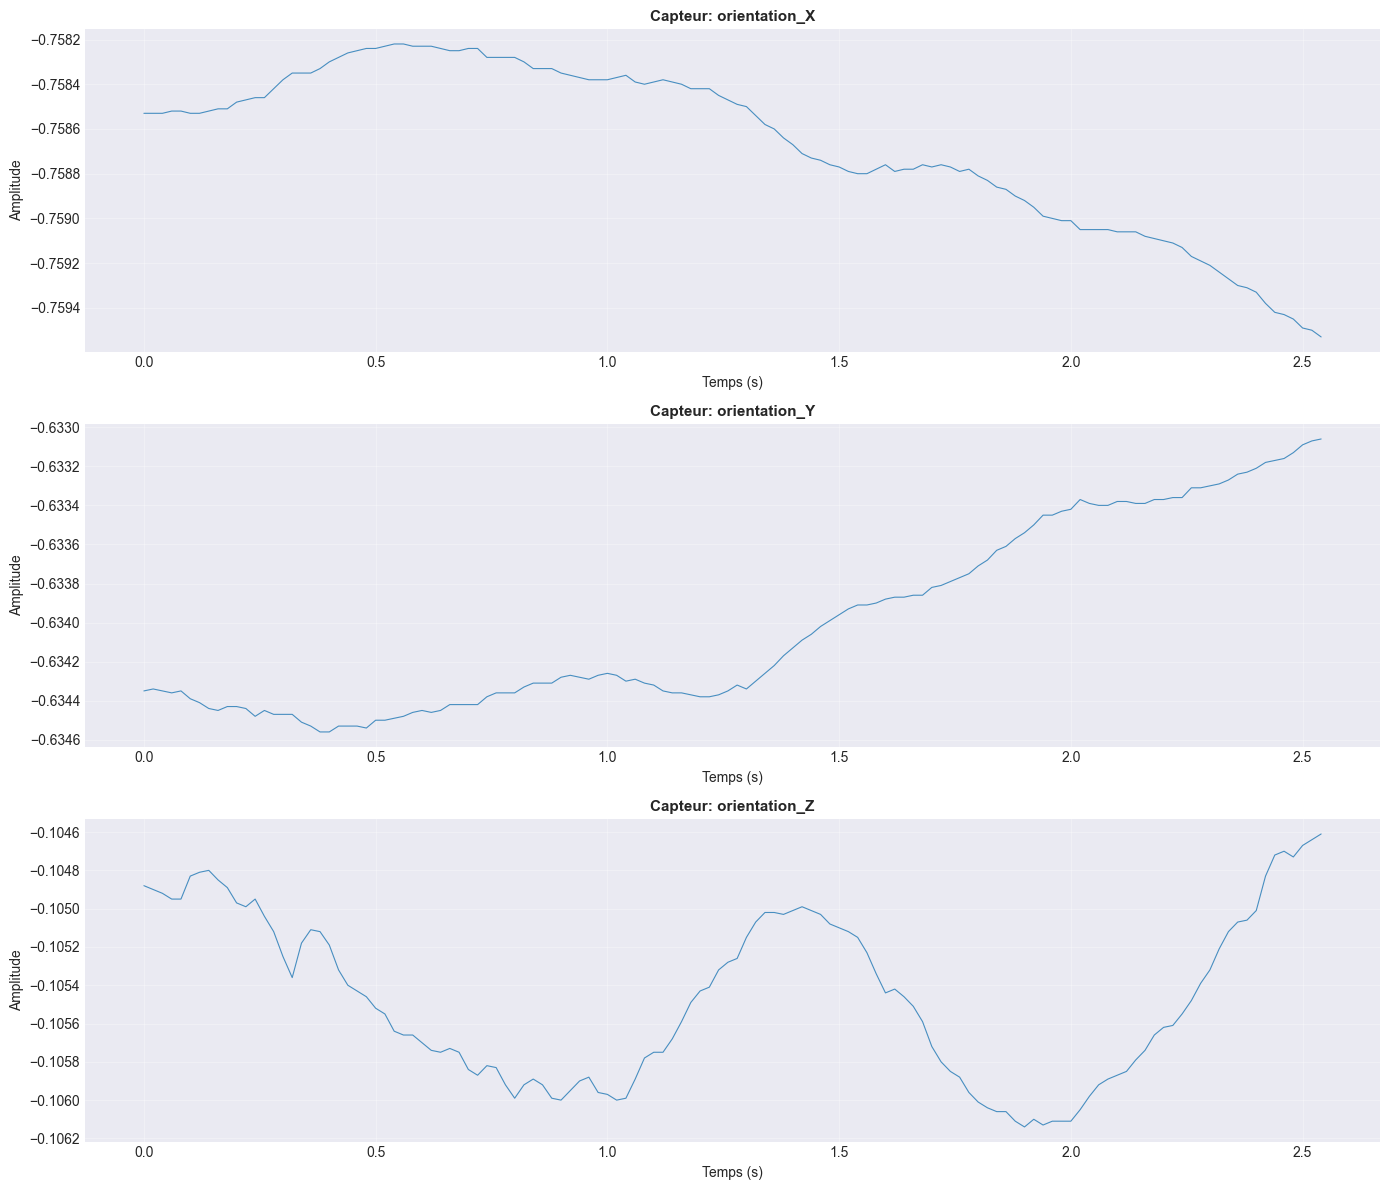

In [26]:
# Visualiser une série exemple
SAMPLING_FREQ = 50.0 # Fréquence d'échantillonnage en Hz
example_id = df[series_col].unique()[0]
example_data = df[df[series_col] == example_id].copy()

if 'measurement_number' in example_data.columns:
    example_data = example_data.sort_values('measurement_number')

print(f"Série exemple: {example_id}")
print(f"   Longueur: {len(example_data)} échantillons")
print(f"   Durée: {len(example_data) / SAMPLING_FREQ:.2f} secondes")

# Visualisation
fig, axes = plt.subplots(len(sensor_cols[:3]), 1, figsize=(14, 4 * min(3, len(sensor_cols))))
if len(sensor_cols) == 1:
    axes = [axes]

time = np.arange(len(example_data)) / SAMPLING_FREQ

for idx, col in enumerate(sensor_cols[:3]):
    ax = axes[idx] if len(sensor_cols[:3]) > 1 else axes[0]
    ax.plot(time, example_data[col].values, linewidth=0.8, alpha=0.8)
    ax.set_title(f'Capteur: {col}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Temps (s)')
    ax.set_ylabel('Amplitude')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Extraction des caractéristiques
Pour toute les séries et les capteurs

In [27]:
from tqdm.auto import tqdm  # Barre de progression

print("Démarrage de l'extraction des features...\n")

all_features = []

# Boucle sur chaque série
for series_id in tqdm(df[series_col].unique(), desc="Séries"):
    series_data = df[df[series_col] == series_id]
    
    # Boucle sur chaque capteur
    for sensor in sensor_cols:
        features = extract_all_features(
            series=series_data[sensor],
            series_id=f"{series_id}_{sensor}",
            fs=SAMPLING_FREQ
        )
        features['sensor_name'] = sensor
        features['original_series_id'] = series_id
        all_features.append(features)

# Créer le DataFrame final
features_df = pd.DataFrame(all_features)

print(f"\n Extraction terminée!")
print(f"   • Nombre de features: {features_df.shape[1]}")
print(f"   • Nombre d'observations: {features_df.shape[0]}")
print(f"   • Colonnes: {list(features_df.columns)}")


c:\Users\mathi\anaconda3\envs\CIAenvpy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Démarrage de l'extraction des features...



Séries: 100%|██████████| 3810/3810 [01:47<00:00, 35.58it/s]



 Extraction terminée!
   • Nombre de features: 39
   • Nombre d'observations: 38100
   • Colonnes: ['series_id', 'mean', 'variance', 'std', 'skewness', 'kurtosis', 'min', 'max', 'range', 'median', 'q25', 'q75', 'iqr', 'n_samples', 'perm_entropy_order3', 'perm_entropy_order5', 'perm_entropy_order7', 'dominant_frequency', 'dominant_power', 'total_power', 'band_power_0_1', 'band_power_1_5', 'band_power_5_10', 'band_power_10_20', 'band_power_20_25', 'spectral_centroid', 'spectral_spread', 'acf_lag1', 'acf_lag5', 'acf_lag10', 'acf_lag20', 'acf_lag50', 'first_deriv_mean', 'first_deriv_std', 'first_deriv_max', 'second_deriv_mean', 'second_deriv_std', 'sensor_name', 'original_series_id']


## Visualisations avancées
Visualisation des caractéristiques extraites

Matrice de corrélation des features



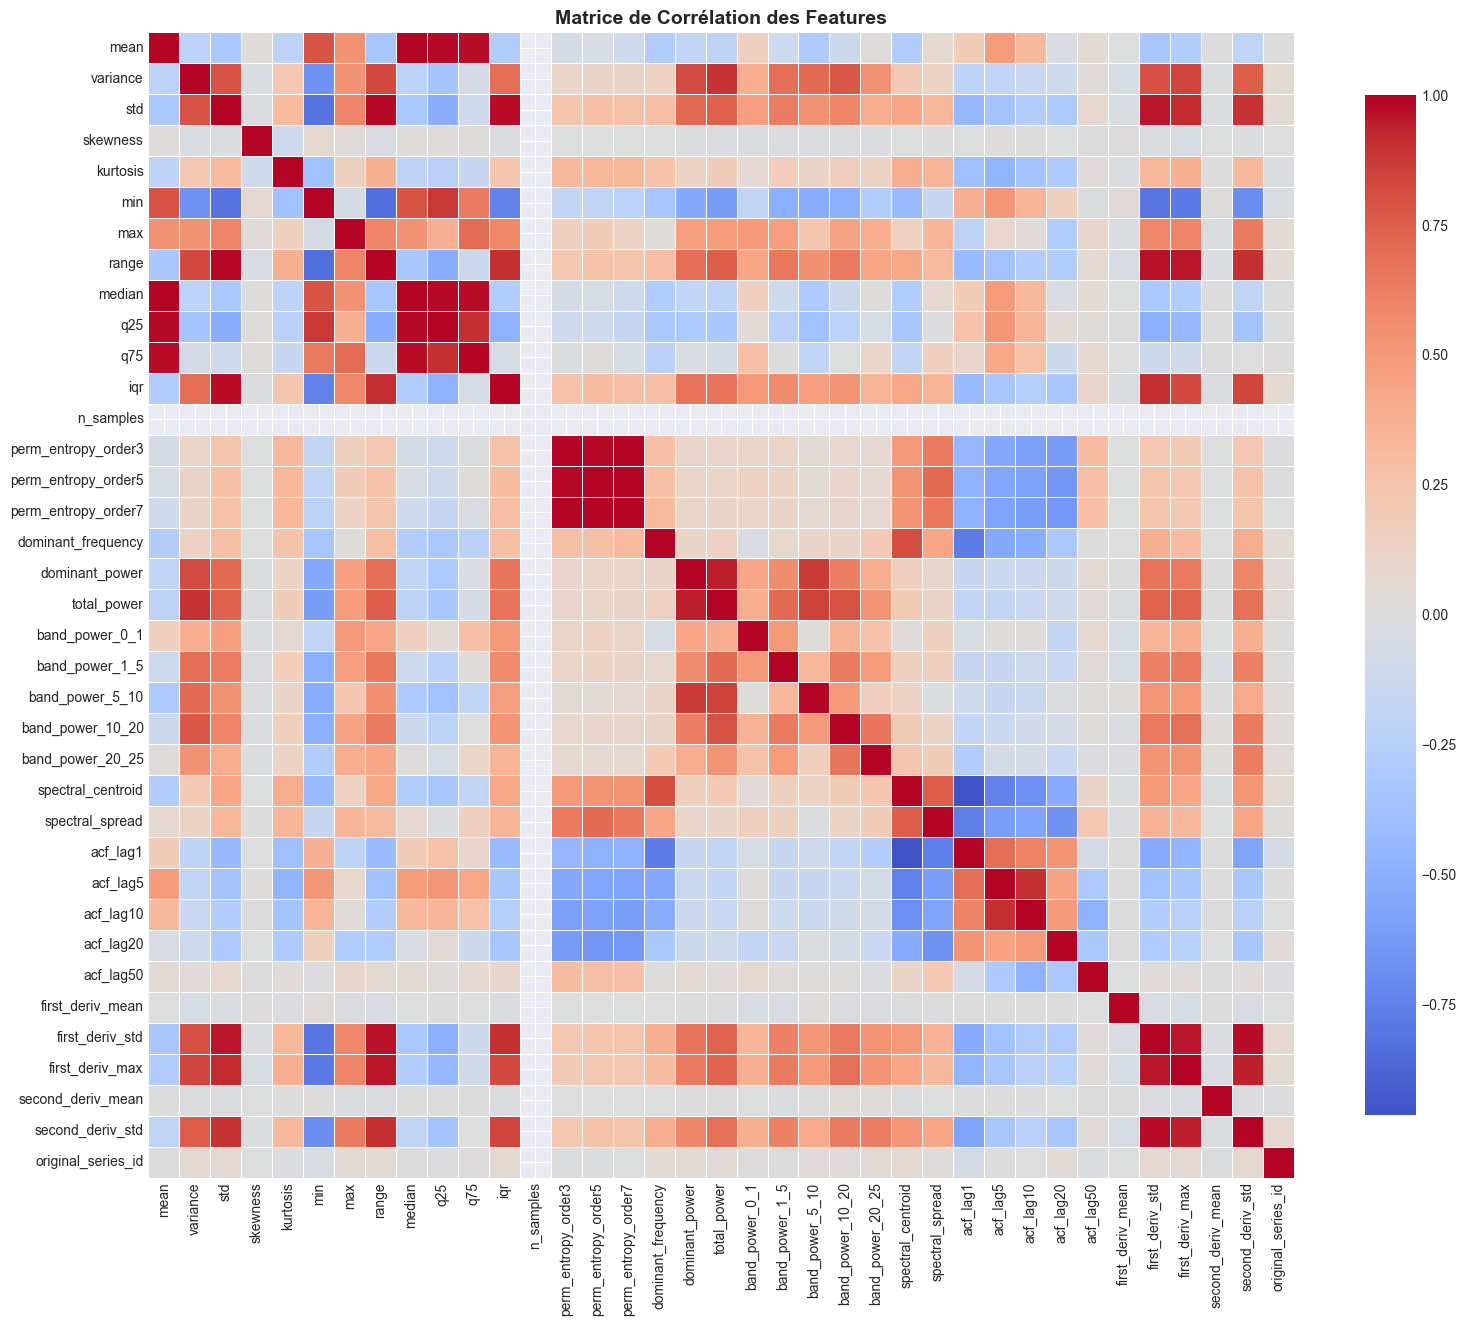


 Features hautement corrélées (|r| > 0.9):
   mean ↔ median: 0.999
   mean ↔ q25: 0.979
   mean ↔ q75: 0.973
   std ↔ range: 0.980
   std ↔ iqr: 0.970
   std ↔ first_deriv_std: 0.956
   std ↔ first_deriv_max: 0.917
   range ↔ iqr: 0.914
   range ↔ first_deriv_std: 0.962
   range ↔ first_deriv_max: 0.957


In [28]:
# Matrice de corrélation des features
print("Matrice de corrélation des features\n")

# Sélectionner les features numériques
numeric_features = features_df.select_dtypes(include=[np.number]).columns
correlation_matrix = features_df[numeric_features].corr()

# Visualiser
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            annot=False)
plt.title('Matrice de Corrélation des Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Identifier les paires hautement corrélées
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr.append({
                'feature1': correlation_matrix.columns[i],
                'feature2': correlation_matrix.columns[j],
                'correlation': correlation_matrix.iloc[i, j]
            })

if high_corr:
    print("\n Features hautement corrélées (|r| > 0.9):")
    for item in high_corr[:10]:
        print(f"   {item['feature1']} ↔ {item['feature2']}: {item['correlation']:.3f}")


Distribution de quelques features clés



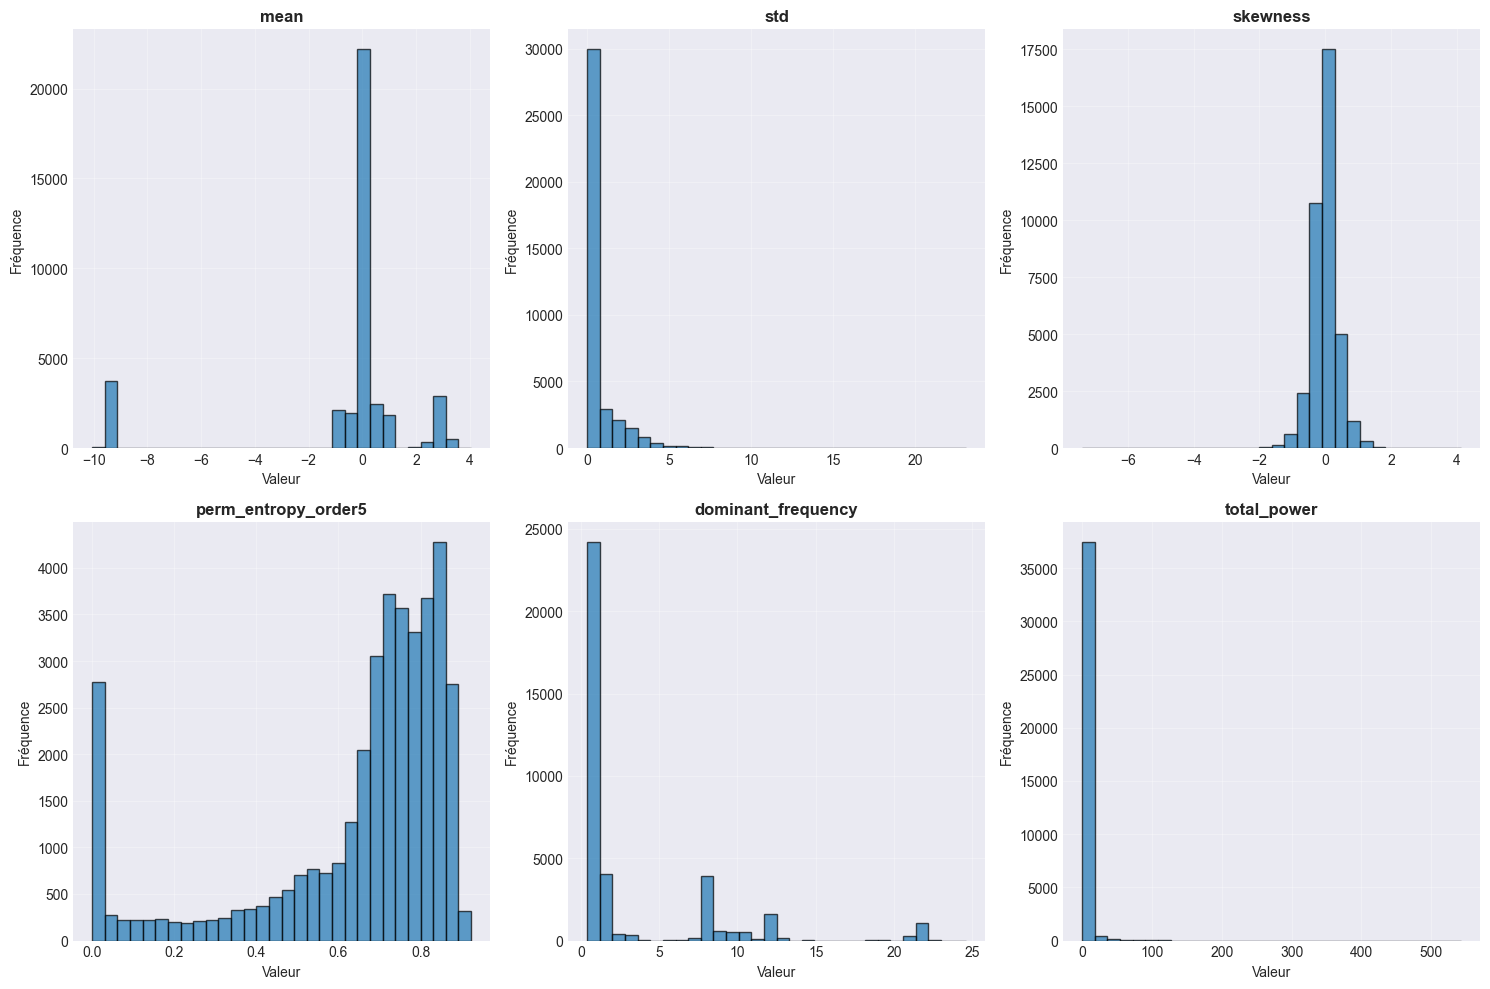

In [29]:
# Distribution des features principales
print("Distribution de quelques features clés\n")

key_features = ['mean', 'std', 'skewness', 'perm_entropy_order5', 
                'dominant_frequency', 'total_power']

available_features = [f for f in key_features if f in features_df.columns]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(available_features):
    if idx < len(axes):
        axes[idx].hist(features_df[feature].dropna(), bins=30, 
                      edgecolor='black', alpha=0.7)
        axes[idx].set_title(feature, fontweight='bold')
        axes[idx].set_xlabel('Valeur')
        axes[idx].set_ylabel('Fréquence')
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Sauvegarde et export
En fichier csv pour réutilisation ultérieur

In [30]:
# Sauvegarder les features
output_file = './features_complete.csv'
features_df.to_csv(output_file, index=False)

print(f"Features sauvegardées: {output_file}")
print(f"   • Shape: {features_df.shape}")
print(f"   • Taille: {os.path.getsize(output_file) / 1024 / 1024:.2f} MB")

# Résumé des features
print("\nRésumé des features extraites:\n")
print(f"   Nombre total: {features_df.shape[1]}")
print(f"\n   Catégories:")
print(f"      • Statistiques globales: mean, std, variance, skewness, kurtosis, etc.")
print(f"      • Entropie de permutation: ordre 3, 5, 7")
print(f"      • Features fréquentielles: puissances de bande, fréquence dominante")
print(f"      • Autocorrélation: lags 1, 5, 10, 20, 50")
print(f"      • Dérivées: moyenne, écart-type, max")


Features sauvegardées: ./features_complete.csv
   • Shape: (38100, 39)
   • Taille: 24.88 MB

Résumé des features extraites:

   Nombre total: 39

   Catégories:
      • Statistiques globales: mean, std, variance, skewness, kurtosis, etc.
      • Entropie de permutation: ordre 3, 5, 7
      • Features fréquentielles: puissances de bande, fréquence dominante
      • Autocorrélation: lags 1, 5, 10, 20, 50
      • Dérivées: moyenne, écart-type, max
